In [1]:
import yfinance as yf

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.preprocessing import MinMaxScalar
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import numpy as np
import xgboost as xgb

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas
import folium
import math
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import ipywidgets as widgets
from ipywidgets import interact
from ipywidgets import HTML
from dash import Dash, html, dcc, callback, Output, Input

In [4]:
from sklearn.preprocessing import MinMaxScaler

https://www.kaggle.com/code/owczar/gam-model-for-time-series-forecasting

# 1.Data Processing
###  - Data: S&P500 index (sp500)

In [7]:
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period ="max")

In [8]:
## Create a new feature called "yesterday" and drop all data with N/A 
sp500['yesterday'] = sp500.Close.shift(1)
sp500 = sp500.dropna()

In [9]:
## Understanding the features
sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24341 entries, 1928-01-03 00:00:00-05:00 to 2024-11-22 00:00:00-05:00
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          24341 non-null  float64
 1   High          24341 non-null  float64
 2   Low           24341 non-null  float64
 3   Close         24341 non-null  float64
 4   Volume        24341 non-null  int64  
 5   Dividends     24341 non-null  float64
 6   Stock Splits  24341 non-null  float64
 7   yesterday     24341 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 1.7 MB


In [10]:
## convert the Sp500 indexes to a data_time object for easier manipulation based on date and time
sp500.index = pd.to_datetime(sp500.index)

# 2. Generating the train and test data 

###  - Methods for generating test/train data

In [13]:
### Used for generating empty df with indexes as dates
### If given 365 days, creates future dates, that only include weekdays.
### It's easy to imagine that it creates 365 days, then discards all the weekends.
### If today is Jan 1, 2024, it will create up to Jan 1, 2025
# input: days (int)
# output: (Pandas DataFrame object) 
def generateFutureDates(days):
    today = pd.to_datetime('today').normalize()
    
    period = days
    pred_range = pd.date_range(start = today, periods = period, freq="D")
    temp_df = pd.DataFrame(index=pred_range)
    temp_df2 = createSeasonalFeatures(temp_df)
    temp_df2 = temp_df2[temp_df2['dayofweek'] < 5]
    return temp_df2

In [14]:
## This method divides the test and train data based on the year given. 
#   input: (type pandas-dataframe, int, int, int, int) df, train_year_start, train_year_end, test_year_start, test_year_end
#   output: (type list list) test, train
def generateTrainTest(train_year_start, train_year_end, test_year_start, test_year_end=0, df=sp500):
    train_year_start = str('01-01-' + str(train_year_start))
    train_year_end = str('31-12-' + str(train_year_end))
    test_year_start = str('01-01-' + str(test_year_start))
    test_year_end = str('31-12-' + str(test_year_end))
    
    
    sp_train = df.iloc[(df.index < train_year_end)& (df.index > train_year_start)] 
    sp_test = None
    ## if no test-
    if(test_year_end == 0):
        sp_test = df.iloc[df.index >= test_year_start]
    sp_test = df.iloc[(df.index < test_year_end)& (df.index > test_year_start)]     
    
    ## Drop data that can cause data leakage
    sp_test.drop('yesterday', axis=1)
    
    return sp_train, sp_test
    

In [15]:


## Define features that will be inspected
# FEATURES_TRAIN = ['quarter', 'year', 'month', 'dayofweek', 'yesterday']
# FEATURES_TEST = ['quarter', 'year', 'month', 'dayofweek', 'abs_date_index']
# TARGET = 'Close'
FEATURES_TRAIN = ['quarter', 'year', 'month', 'dayofweek', 'yesterday']
FEATURES_TEST = ['quarter', 'year', 'month', 'dayofweek']
TARGET = 'Close'


## given a df, it adds seasonal features defined above
## new values are also generated based on the date information in the df
# Input: DF object
# Output: DF object

def createSeasonalFeatures(df):
    DF = df.copy()
    DF["quarter"] = df.index.quarter    
    DF["year"] = df.index.year
    DF["month"] = df.index.month
    DF["dayofweek"] = df.index.dayofweek
    # DF["abs_date_index"] = (df.index.dayofyear * (1/365) ) + df.index.year
    return DF

In [16]:
# Accepts TRAIN data and returns X and Y
def separateTrainXY(train_data, features, target):
    FEATURES = features
    TARGET = target
    x_train = train_data[FEATURES_TRAIN] 
    y_train = train_data[TARGET]
    return x_train, y_train

# Accepts TEST data and returns X and Y
def separateTestXY(test_data, features, target):    
    FEATURES_TEST = features
    TARGET = target
    x_test = test_data[FEATURES_TEST]
    y_test = test_data[TARGET]
    return x_test, y_test

### - generating test data and visualization

#####   NOTE • Range of data for train data [1980-2020]   • Range of data for test data [2021-2024]

In [19]:
# ## BLOCK THAT Preprocesses 

# ## Acquire training and test data
# train, test = generateTrainTest(1980, 2020, 2021,2024)
# ## Add on seasonal data (quarter, month, day, etc)
# test = createSeasonalFeatures(test)
# train = createSeasonalFeatures(train)
# ## Separate X and y
# x_train, y_train = separateTrainXY(train, FEATURES_TRAIN, TARGET)
# x_test, y_test = separateTestXY(test, FEATURES_TEST, TARGET)

In [20]:
## quick preprocess for future

def generate(train_start, train_end, test_start, test_end, FEATURES_TRAIN, FEATURES_TEST, TARGET):
    ## Acquire training and test data
    _train_, _test_ = generateTrainTest(train_start, train_end, test_start, test_end)
    ## Add on seasonal data (quarter, month, day, etc)
    _test_ = createSeasonalFeatures(_test_)
    _train_ = createSeasonalFeatures(_train_)
    ## Separate X and y
    _x_train_, _y_train_ = separateTrainXY(_train_, FEATURES_TRAIN, TARGET)
    _x_test_, _y_test_ = separateTestXY(_test_, FEATURES_TEST, TARGET)
    dictionary = {        
        "train": _train_,
        "test": _test_,
        "x_train": _x_train_,
        "y_train":_y_train_,
        "x_test":_x_test_,
        "y_test":_y_test_
    }
    return dictionary

In [21]:
data = generate(1980, 2020, 2021,2024, FEATURES_TRAIN, FEATURES_TEST, TARGET)

In [23]:
## Visualize Training Data(red) and Testing Data(blue)
fig, ax = plt.subplots(figsize = (15,5))
data['test'].Close.plot(ax = ax, label="test data", color = "blue")
data['train'].Close.plot(ax = ax, label="train data", color = "red")
ax.legend()

####  - generating input X and output Y for both test and train data 

# 3. Training the Model

In [32]:
model1 = xgb.XGBRegressor(n_estimators=3000, learning_rate = 0.02, max_depth=10)
model1.fit(data['x_train'], data['y_train'], 
           verbose = True)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=3000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [33]:
pd.DataFrame(data = model1.feature_importances_,
            index = FEATURES_TRAIN,
            columns = ["importance"])

importance
quarter      0.000093
year         0.059484
month        0.000108
dayofweek    0.000073
yesterday    0.940241

In [34]:
def modelPredict(model_, train, test, x_test):
    x_test_ = x_test.copy()
    last_close_price = train.iloc[-1].Close

    ## DataFrame to store predictions
    predictions = []

    
    ## Predict day by day
    for i in range(len(x_test_)):
        current_features = x_test_.iloc[[i]].copy()
        
        current_features["yesterday"] = last_close_price


        ## Predict stock price for the current day
        predicted = model_.predict(current_features)
        
        ## temp add to add date exp
        # predicted *
        predictions.append(predicted)
        last_close_price = predicted
    

    pred_list = []
    for i, element in enumerate(predictions):
        pred_list.append(element[0])
    
    x_test_['prediction'] = pred_list
        
    return x_test_


# 4.Visualization Tools

In [37]:
def visualizePredictions(prediction, df):
    ax = df['Close'].plot( color = "black", label='actual')
    prediction['prediction'].plot(ax=ax, color = "purple", label='predicted')
    ax.legend()
    plt.show()

In [41]:
def visualizePredictionsArtificialInflation(prediction, df):
    incremented_predictions = prediction.copy()
    incremented_predictions['prediction'] = incremented_predictions['prediction'] + range(1, 2 * len(prediction) + 1, 2)
    ax = df['Close'].plot( color = "black", label='actual')
    incremented_predictions['prediction'].plot(ax=ax, label='prediction', color = "purple")
    ax.legend()
    plt.show()

In [43]:
def PLTvisualize(prediction_of_df, df, save_html=False):
    trace = px.line(data_frame = df, y = 'Close', color_discrete_sequence=['black'])
    trace.data[0].name = "real data"

    
    
    fig = px.line(data_frame = prediction_of_df, y = 'prediction', color_discrete_sequence=['red'])
    fig.data[0].name = "predicted"
    fig.add_trace(trace.data[0])



    fig.update_traces(name='Predicted Close', selector=dict(name='y'))
    fig.data[1].name = 'Actual Close'
    fig.data[0].showlegend = True
    fig.data[1].showlegend = True


    fig.update_layout(
        height=600,
        width=1000,
        title='S&P 500 Actual vs Predicted Close Prices',
        xaxis=dict(tickangle=-90),
        legend_title='Legend',
        font=dict(size=18)
    )

    fig.show()
    
    if save_html:
        ## function for creating html file for this plot
        fig.write_html('model_test.html')

# 5. Visualization & Evaluate

In [48]:
## Method for score evaluation
def getRMSE(predicted, actual):
    RMSE_score = 0
    if len(predicted) != len(actual):
        print("make sure that input1(predicted) and input2(actual) have the same lengths")
    else:
        for i in range(len(predicted)):
            delta = predicted.iloc[i].prediction - actual.iloc[i].Close
            RMSE_score += delta**2

    RMSE_score = RMSE_score/len(predicted)
    return RMSE_score

In [52]:
predictions1 = modelPredict(model1, data['train'], data['test'], data['x_test'])

In [54]:
PLTvisualize(predictions1, data['test'])

In [56]:
RMSE = getRMSE(predictions1, data['test']) 
print("RMSE XGBoost:", RMSE)

RMSE XGBoost: 2545336.93078242


### Let's try artificially uniformily increase the prediction values

In [59]:
predictions_inflated = predictions1.copy()
predictions_inflated['prediction'] = predictions_inflated['prediction'] + 1200 
PLTvisualize(predictions_inflated, data['test'])

In [61]:
RMSE_inflated = getRMSE(predictions_inflated, data['test']) 
print("RMSE XGBoost:", RMSE_inflated)

RMSE XGBoost: 359587.6192503661


## • Verdict: by visual investigation, the model seems to do somewhat of a "decent" job by simple visual inspection. But the RMSE is too high, and it can't discover new highs; showing that it is not able to learn inflation.

# 6. Using Different Models

### 6-1 GAMs for Time Series

In [306]:
from pygam import GAM, s, te

In [226]:
GAM?

Init signature:
GAM(
    terms='auto',
    max_iter=100,
    tol=0.0001,
    distribution='normal',
    link='identity',
    callbacks=['deviance', 'diffs'],
    fit_intercept=True,
    verbose=False,
    **kwargs,
)
Docstring:     
Generalized Additive Model

Parameters
----------
terms : expression specifying terms to model, optional.

    By default a univariate spline term will be allocated for each feature.

    For example:

    >>> GAM(s(0) + l(1) + f(2) + te(3, 4))

    will fit a spline term on feature 0, a linear term on feature 1,
    a factor term on feature 2, and a tensor term on features 3 and 4.

callbacks : list of str or list of CallBack objects, optional
    Names of callback objects to call during the optimization loop.

distribution : str or Distribution object, optional
    Distribution to use in the model.

link : str or Link object, optional
    Link function to use in the model.

fit_intercept : bool, optional
    Specifies if a constant (a.k.a. bias or interce

In [308]:
gam = GAM(s(0) + s(1) + s(2) + s(3) + te(0,3))

In [310]:
temp_train = data['x_train'].copy()
temp_train = temp_train.drop('yesterday', axis=1)
gam.fit(temp_train, data['y_train'])

GAM(callbacks=[Deviance(), Diffs()], distribution=NormalDist(), 
   fit_intercept=True, link=IdentityLink(), max_iter=100, 
   terms=s(0) + s(1) + s(2) + s(3) + te(0, 3) + intercept, tol=0.0001,
   verbose=False)

In [312]:

predictions_gam = gam.predict(data['x_test'])

In [314]:
predictions_gam_df = data['x_test'].copy()
predictions_gam_df['prediction'] = predictions_gam

In [316]:
predictions_gam_df

quarter  year  month  dayofweek   prediction
Date                                                                   
2021-01-04 00:00:00-05:00        1  2021      1          0  3433.588297
2021-01-05 00:00:00-05:00        1  2021      1          1  3434.156027
2021-01-06 00:00:00-05:00        1  2021      1          2  3435.611575
2021-01-07 00:00:00-05:00        1  2021      1          3  3434.971290
2021-01-08 00:00:00-05:00        1  2021      1          4  3434.559004
...                            ...   ...    ...        ...          ...
2024-11-18 00:00:00-05:00        4  2024     11          0  4268.612251
2024-11-19 00:00:00-05:00        4  2024     11          1  4270.410183
2024-11-20 00:00:00-05:00        4  2024     11          2  4268.698347
2024-11-21 00:00:00-05:00        4  2024     11          3  4268.193156
2024-11-22 00:00:00-05:00        4  2024     11          4  4268.223475

[980 rows x 5 columns]

In [318]:
PLTvisualize(predictions_gam_df, data['test'])

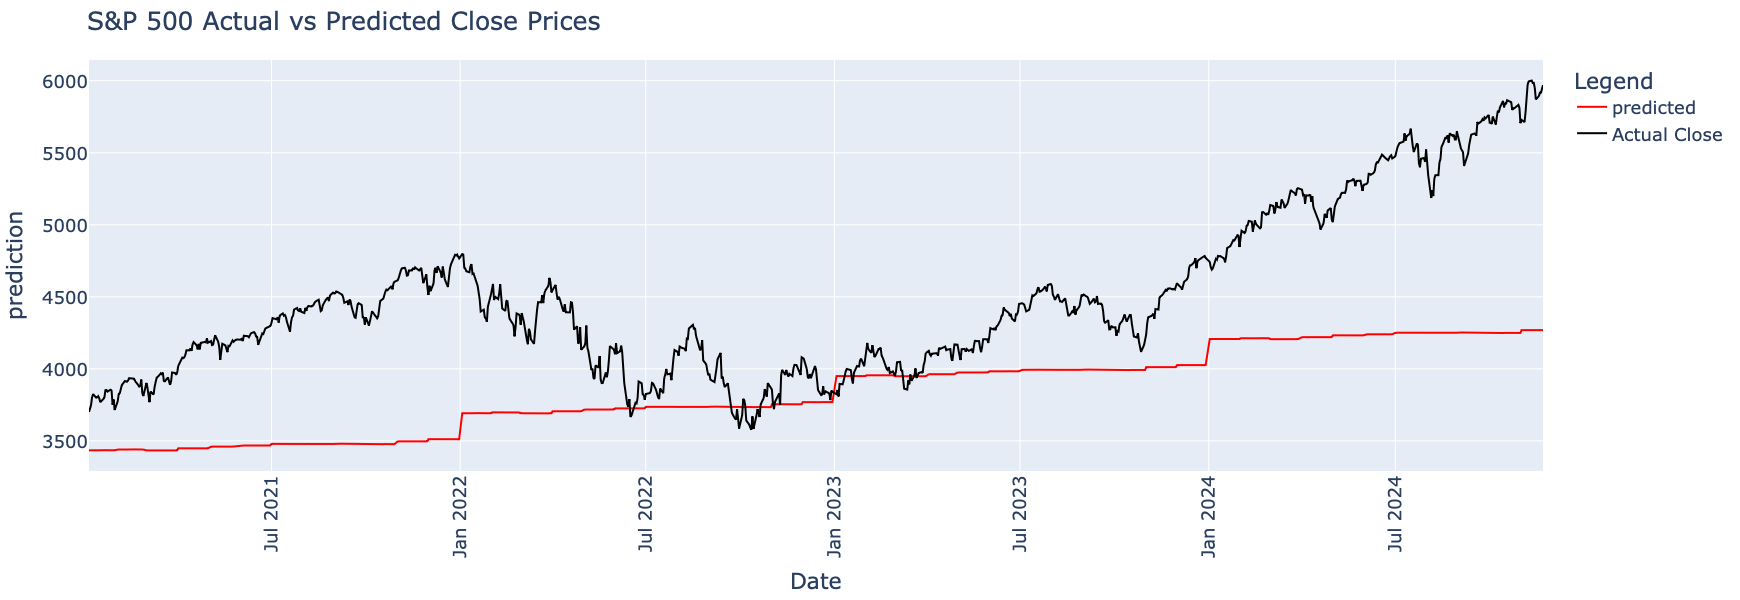

In [194]:
PLTvisualize(predictions_gam_df, data['test'])

In [232]:
# fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # Adjust to match the number of features

# for i, ax in enumerate(axs):
#     gam.partial_dependence(term=i, ax=ax)
#     ax.set_title(f'Feature {i}')

gam?

Type:           GAM
String form:   
GAM(callbacks=[Deviance(), Diffs()], distribution=NormalDist(),
           fit_intercept=True, link=Iden <...> (), max_iter=100,
           terms=s(0) + s(1) + s(2) + s(3) + intercept, tol=0.0001,
           verbose=False)
File:           ~/anaconda3/lib/python3.11/site-packages/pygam/pygam.py
Docstring:     
Generalized Additive Model

Parameters
----------
terms : expression specifying terms to model, optional.

    By default a univariate spline term will be allocated for each feature.

    For example:

    >>> GAM(s(0) + l(1) + f(2) + te(3, 4))

    will fit a spline term on feature 0, a linear term on feature 1,
    a factor term on feature 2, and a tensor term on features 3 and 4.

callbacks : list of str or list of CallBack objects, optional
    Names of callback objects to call during the optimization loop.

distribution : str or Distribution object, optional
    Distribution to use in the model.

link : str or Link object, optional
    Link

In [196]:
RMSE = getRMSE(predictions_gam_df, data['test']) 
print("RMSE XGBoost:", RMSE)

RMSE XGBoost: 597139.9255599611


In [214]:
dummy = data['x_train'].copy()
dummy = dummy.drop('yesterday', axis=1)
predictions_gam_dummy = gam.predict(dummy)

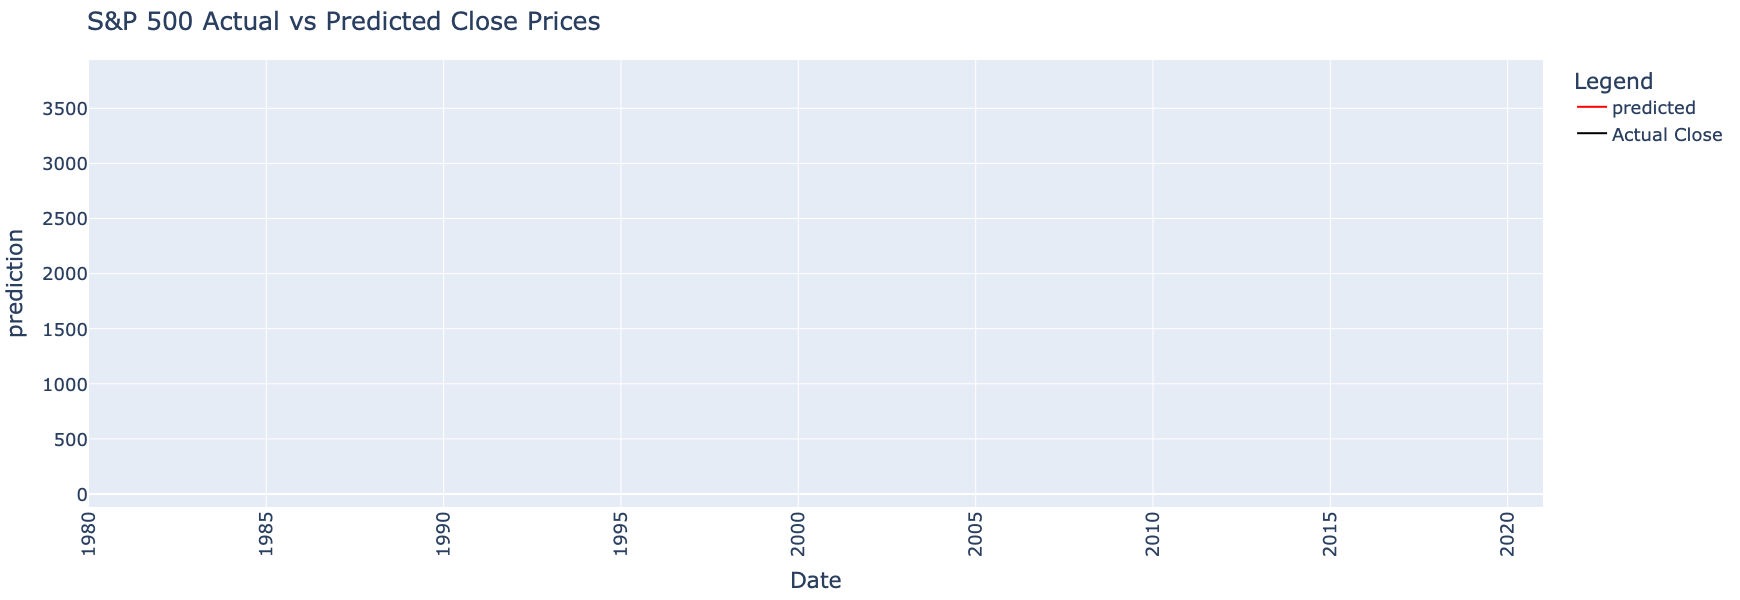

In [224]:
predictions_gam_dummy_df = data['x_train'].copy()
predictions_gam_dummy_df['prediction'] = predictions_gam_dummy
PLTvisualize(predictions_gam_dummy_df, data['train'])

### 6-b 

In [ ]:
6-1